In [1]:
%cd "baselines/Copolymer"

/home/zmao_umass_edu/baselines/Copolymer


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [28]:
import pandas as pd
import numpy as np
import pickle

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dense, Flatten, Activation, ZeroPadding2D
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional, TimeDistributed, Reshape, Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time
from tensorflow.keras import layers
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import random
from numpy.random import seed
import tensorflow
from keras.layers import Input
from keras.models import Model
from keras.layers import Concatenate
import argparse
import os
import matplotlib.pyplot as plt


In [4]:
#read in the reference data
DF = pd.read_csv('datasets/Dataset 1.csv') #to be comparable with the size of other datasets, select ~5000 data points from the reference
DF['TRIMER_mol'] = DF['TRIMER'].apply(Chem.MolFromSmiles)
DF = DF.dropna()
#DF = DF.head(20000)

In [5]:
nbits = 1024#1024
fp = DF['TRIMER_mol'].apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=3, nBits=nbits))

In [6]:
fp[0].ToBitString()

'000000000000000100000000000000000010100000000000000000000000000010000000001000000001000000100000000000100000000000000000000000000000001010000000001100000000000000000000000000000000000000001000000000000001000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000110000000010000001000011001000000000000001000000000000010001100000000100010000000000000000000100000000000000000000000000000001001000000000000000000000000000000000010000000000000000010000000000000000000000000000000000000010000000000000000000000100000000001000000000100000000000000000000010000000000000000001000001000000011000010000000000000000000000000001001000001000000000000000100000000100000001100000100000000000000000000000000100000000000000000000000000000000000000000000000000000000001000100000000000000010000000000100000000000000000000000001000000100000000000010000000000001100000000000000000001000000010000000000000000000001000000000000010000000000000000010000100000000000000000000100000000000000

In [7]:
np.array(fp[0])

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
fp_array = np.asarray([np.array(fp[i]) for i in range(len(fp))])

In [9]:
fp_array.shape

(47988, 1024)

In [10]:
Mix_X_100Block = np.repeat(fp_array, 100, axis=0)
Mix_X_100Block = Mix_X_100Block.reshape(len(DF), 100, nbits)

In [11]:
Mix_X_100Block.shape

(47988, 100, 1024)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(Mix_X_100Block, DF['IP (eV)'], test_size=0.2, random_state=11)

In [13]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [14]:
# X_train_reshaped = np.expand_dims(X_train, axis=1)
# X_train = X_train_reshaped

In [15]:
X_train = X_train.astype('int64')
y_train = y_train.astype('int64' )

In [19]:
# # model setup using the optimized architecture for IP
LSTMunits = 20 # hyperprameter for LSTM

# # ### multiple GPU
# with strategy.scope():
#     RNNmodel = Sequential()
#     RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True), input_shape=(100,2048)))
#     RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
#     RNNmodel.add(TimeDistributed(tensorflow.keras.layers.Dense(int(LSTMunits/2), activation="relu")))
#     RNNmodel.add(Reshape((int(LSTMunits/2*100),)))
#     RNNmodel.add(Dense(1))
#     RNNmodel.compile(loss='mse', optimizer='adam')
# RNNmodel.fit(X_train, y_train, validation_split=0.2, epochs=120, batch_size=2)

# ### Single GPU:
RNNmodel = Sequential()
RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True), input_shape=(100,1024)))
RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
RNNmodel.add(TimeDistributed(tensorflow.keras.layers.Dense(int(LSTMunits/2), activation="relu")))
RNNmodel.add(Reshape((int(LSTMunits/2*100),)))
RNNmodel.add(Dense(1))
RNNmodel.compile(loss='mse', optimizer='adam')


In [23]:
RNNmodel.fit(X_train, y_train, validation_split=0.2, epochs=120, batch_size=32)

Epoch 1/120
960/960 [==============================] - 45s 47ms/step - loss: 0.0123 - val_loss: 0.0172
Epoch 2/120
960/960 [==============================] - 46s 48ms/step - loss: 0.0102 - val_loss: 0.0179
Epoch 3/120
960/960 [==============================] - 46s 47ms/step - loss: 0.0089 - val_loss: 0.0198
Epoch 4/120
960/960 [==============================] - 46s 47ms/step - loss: 0.0088 - val_loss: 0.0170
Epoch 5/120
960/960 [==============================] - 46s 48ms/step - loss: 0.0074 - val_loss: 0.0211
Epoch 6/120
960/960 [==============================] - 46s 47ms/step - loss: 0.0071 - val_loss: 0.0161
Epoch 7/120
960/960 [==============================] - 45s 47ms/step - loss: 0.0061 - val_loss: 0.0158
Epoch 8/120
960/960 [==============================] - 45s 47ms/step - loss: 0.0056 - val_loss: 0.0164
Epoch 9/120
960/960 [==============================] - 45s 47ms/step - loss: 0.0049 - val_loss: 0.0162
Epoch 10/120
960/960 [==============================] - 45s 47ms/step - l

Epoch 80/120
960/960 [==============================] - 46s 48ms/step - loss: 0.0012 - val_loss: 0.0153
Epoch 81/120
960/960 [==============================] - 46s 48ms/step - loss: 0.0012 - val_loss: 0.0152
Epoch 82/120
960/960 [==============================] - 45s 47ms/step - loss: 0.0012 - val_loss: 0.0169
Epoch 83/120
960/960 [==============================] - 46s 48ms/step - loss: 0.0012 - val_loss: 0.0152
Epoch 84/120
960/960 [==============================] - 46s 48ms/step - loss: 0.0012 - val_loss: 0.0154
Epoch 85/120
960/960 [==============================] - 46s 48ms/step - loss: 0.0012 - val_loss: 0.0155
Epoch 86/120
960/960 [==============================] - 46s 48ms/step - loss: 0.0012 - val_loss: 0.0157
Epoch 87/120
960/960 [==============================] - 46s 48ms/step - loss: 0.0012 - val_loss: 0.0156
Epoch 88/120
960/960 [==============================] - 46s 48ms/step - loss: 0.0013 - val_loss: 0.0152
Epoch 89/120
960/960 [==============================] - 46s 47ms

In [24]:
filepath = 'Binary_IP_RNN_1024_bit_full.model'
save_model(RNNmodel, filepath, save_format='h5')

In [25]:
# model evaluation
print("model performance (EA)")
y_pred_train = RNNmodel.predict((X_train))
print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MAE score: %.2f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))
y_pred_test = RNNmodel.predict((X_test))
print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MAE score: %.2f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

model performance (EA)
Train set R^2: 0.98
Train MAE score: 0.03
Train RMSE score: 0.06
Test set R^2: 0.94
Test MAE score: 0.08
Test RMSE score: 0.12


In [26]:
y_pred_test = y_pred_test.ravel()

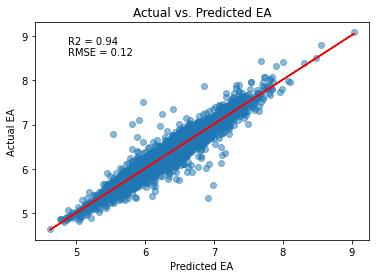

In [29]:
plt.scatter(y_pred_test, y_test, alpha=0.5)


r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))


plt.text(0.1, 0.9, "R2 = {:.2f}".format(r2), transform=plt.gca().transAxes)
plt.text(0.1, 0.85, "RMSE = {:.2f}".format(rmse), transform=plt.gca().transAxes)

m, b = np.polyfit(y_pred_test, y_test, 1)
plt.plot(y_pred_test, m*y_pred_test + b, color='red')


plt.xlabel("Predicted EA")
plt.ylabel("Actual EA")
plt.title("Actual vs. Predicted EA")

plt.show()